# Enefit - Predict Energy Behavior of Prosumers
<h4>Predict Prosumer Energy Patterns and Minimize Imbalance Costs:</h4>
<p>Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.</p>

<b>Estonia: 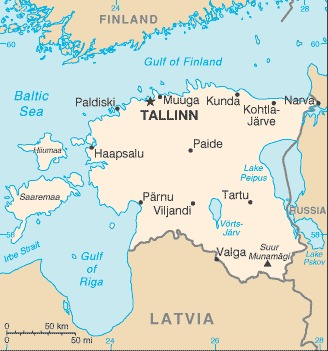 centroid = (26.0, 59.0) 

In [1]:
import os
import json
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
import geopandas as gpd

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [4]:
import datetime
import pytz
import holidays
import optuna
import joblib

In [5]:
from typing import Optional,Dict,Tuple
from pathlib import Path

In [106]:
import xgboost
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [7]:
# module_path = os.path.abspath(os.path.join('.'))

# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# from utils.solar_tracking import calculate_elevation_angle, calculate_irradiation_on_surface, when_is_daylight

In [8]:
# os.chdir('predict-energy-behavior-of-prosumers/')
plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

### Map Weather Sample Points

In [9]:
INPUT_DIR = os.path.join(os.getcwd(), "input")

ESTONIA_GPKG = os.path.join(INPUT_DIR, "estonia.gpkg")

# Coordinate Reference System (CRS)
ESTONIA_CRS = "EPSG:4133"

In [10]:
# Read in all spatial layers
# boundary = gpd.read_file(ESTONIA_GPKG, layer='boundary', driver="GPKG", crs=ESTONIA_CRS)
counties = gpd.read_file(ESTONIA_GPKG, layer='counties', driver="GPKG", crs=ESTONIA_CRS)
# municipalities = gpd.read_file(ESTONIA_GPKG, layer='municipalities', driver="GPKG", crs=ESTONIA_CRS)
settlements = gpd.read_file(ESTONIA_GPKG, layer='settlements', driver="GPKG", crs=ESTONIA_CRS)
samples = pd.read_csv(os.path.join(INPUT_DIR, 'weather_station_to_county_mapping.csv'))
dtypes={'latitude': 'float', 'longitude': 'float', 'county': 'int'}
samples = samples.dropna()
samples = samples.sort_values(by='longitude', ascending=True).sort_values(by='latitude', ascending=False).sort_values(by='county', ascending=True)
samples = samples.reset_index(drop=True)

In [11]:
samples = samples.reset_index()

In [12]:
samples = samples.rename(columns={'index': 'sample_point'})

In [13]:
for col, dtype in dtypes.items():
    samples[col] = samples[col].astype(dtype)
    if dtype == 'float':
        samples[col] = samples[col].apply(lambda x: round(x, 1))

samples_gdf = gpd.GeoDataFrame(
    samples, geometry=gpd.points_from_xy(samples.longitude, samples.latitude), crs=ESTONIA_CRS
)

In [14]:
weather = pd.read_csv(os.path.join(INPUT_DIR, 'historical_weather.csv'), parse_dates=['datetime'], dtype={'data_block_id': 'int'})
# forecast = pd.read_csv(os.path.join(INPUT_DIR,'forecast_weather.csv'), parse_dates=['origin_datetime', 'forecast_datetime'], dtype={'data_block_id': 'int'})

In [15]:
weather_gdf = gpd.GeoDataFrame(
    weather, geometry=gpd.points_from_xy(weather.longitude, weather.latitude), crs=ESTONIA_CRS
)

In [16]:
weather_gdf_first = weather_gdf[weather_gdf.datetime == weather_gdf.datetime.min()].reset_index().rename(columns={'index': 'sample_point'})

### Show Map

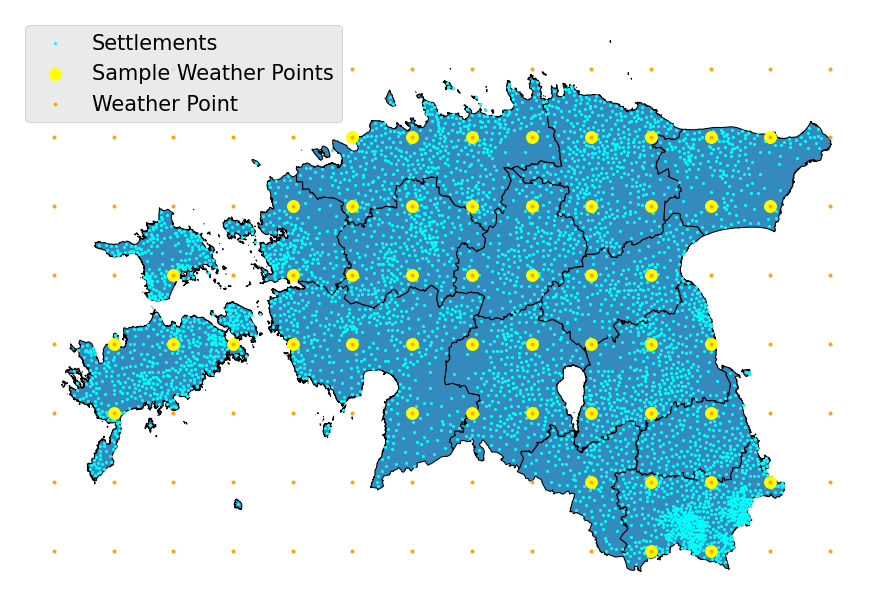

In [17]:
# Plot the counties of Estonia as well as the centroids of the Weather Data Sample Points
fig, ax = plt.subplots(figsize=(6,8))
counties.plot(edgecolor='k',ax=ax)
settlements.centroid.plot(markersize=1, color='cyan', ax=ax, label="Settlements")
samples_gdf.centroid.plot(markersize=32, color='yellow', ax=ax, label="Sample Weather Points")
weather_gdf_first.centroid.plot(markersize=2, color='orange', ax=ax, label="Weather Point")
plt.legend()
plt.axis('off')
plt.tight_layout();

### Weather Aggregation

#### Create Mapping from County to Sample Point

In [18]:
pts_per_sample_gdf = gpd.sjoin_nearest(settlements, weather_gdf_first, distance_col='dist')

In [19]:
pts_per_sample_gdf = pts_per_sample_gdf[pts_per_sample_gdf.dist <= 0.07072]

In [20]:
county_codes = pts_per_sample_gdf.countyCodes.drop_duplicates().to_list()

In [21]:
county_to_sample_lookup_counts = {}

for ctc in county_codes:
    filt_df = pts_per_sample_gdf[pts_per_sample_gdf.countyCodes == ctc]
    sample_points = filt_df.sample_point.drop_duplicates().to_list()

    if ctc not in county_to_sample_lookup_counts:
        county_to_sample_lookup_counts[ctc] = {}
    
    for sp in sample_points:
        county_to_sample_lookup_counts[ctc][sp] = len(filt_df[filt_df.sample_point == sp])
    

In [22]:
county_to_sample_lookup = {}
for ctc, counts in county_to_sample_lookup_counts.items():
    if ctc not in county_to_sample_lookup:
        county_to_sample_lookup[ctc] = {}
        
    count_total = sum(counts.values())
    for sp, count_per_sp in counts.items():
        county_to_sample_lookup[ctc][sp] = count_per_sp/count_total
        

In [23]:
county_mapping = pts_per_sample_gdf[['countyCodes', 'sample_point', 'geometry', 'latitude', 'longitude']].drop_duplicates()

In [24]:
weather = gpd.sjoin_nearest(weather_gdf, county_mapping, distance_col='dist')
weather = weather[weather.dist <= 0.07072]

In [25]:
weather = weather.rename(columns={'countyCodes': 'county', 'longitude_left': 'longitude', 'latitude_left': 'latitude'})
del weather['index_right']
del weather['dist']
del weather['longitude_right']
del weather['latitude_right']

#### Create Distribution of Sample Point Weather Data

In [50]:
filter_agg_columns = ['datetime', 'sample_point', 'county', 'latitude', 'longitude', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 
                      'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
                     'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation']
filter_agg_values = [
    'latitude', 'longitude',
    'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 
    'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
    'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation'
]
weather_agg = weather[filter_agg_columns]

In [27]:
weather_agg['multiplier'] = weather_agg[['county', 'sample_point']].apply(lambda x: county_to_sample_lookup[str(x[0])][x[1]], axis=1)
for col in filter_agg_values:
    weather_agg[col] = weather_agg[col] * weather_agg['multiplier']

In [28]:
approx_weather = weather_agg.groupby(by=['datetime', 'county']).sum().reset_index()

In [51]:
for col in filter_agg_values:
    approx_weather[col] = approx_weather[col] / train['multiplier']

In [30]:
del approx_weather['sample_point']
del approx_weather['multiplier']

### Helper Functions for Handling Datetime

In [31]:
def bin_data(values, k, interval="equal"):
    """
    Given a list of values, 'k' bin
    return categorical bin group ids in specified intervals
    """
    min_val = values.min()
    max_val = values.max()
    
    binned_data = []
    thresholds = []
    
    if interval == "equal":
        intv = (max_val - min_val) / k
        thresholds = [i*intv for i in range(k)]
        
    elif interval == "stdev":
        intv = values.std()
        avg = values.mean()
        if k % 2 == 0:
            k_half = int(k/2)
            k_res = 0
        else:
            k_half = int((k-1)/2)
            k_res = 0.5
            
        for i in range(-1*k_half, k_half+1):
            if i == 0 and k_res == 0:
                pass
            else:
                thresholds.append((i*intv) + avg)

    elif interval == "equal_count":
        pass
        
    elif interval == "quantile":
        pass
    
    elif interval == "log_scale":
        pass

    else:
        pass
    

    binned_data = []
    for val in values:
        for j in range(0, len(thresholds)):
            if val < thresholds[j]:
                binned_data.append(j)
            else:
                pass
    
    return pd.Series(binned_data)
    
    


def extract_dt_attributes(df: pd.DataFrame):
    earliest_time = df.datetime.min()
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    
    #
    df['year'] = df['datetime'].dt.year
    df['day_of_year'] = df['datetime'].dt.strftime('%j').astype(int)
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    
    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)
        
        
        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)
        
        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')
    return df


def handle_timezone(dt: datetime):
    """
    https://www.timeanddate.com/time/change/estonia/tallinn
    """
    year = dt.year
    
    if year == 2021:
        
        if dt >= datetime.datetime.strptime("2021-10-31 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
    elif year == 2022:
        
        if dt < datetime.datetime.strptime("2022-03-27 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        elif dt >= datetime.datetime.strptime("2022-10-30 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
        
    elif year == 2023:
        
        if dt < datetime.datetime.strptime("2023-03-26 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
            
        elif dt >= datetime.datetime.strptime("2023-10-29 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        
        else:
            utc_offset = 3
        
        
    else:
        pass
    
    return utc_offset

def datetime_inference_attributes(dt: datetime):
    
    # dates and times
    date = dt.date
    time = dt.strftime('%H:%M:%S')

    year = dt.year
    day_of_year = dt.timetuple().tm_yday
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    time_data = {}
    
    for key in time_features:
        if col=='week':
            time_data[key] = dt.isocalendar().week.astype(np.int32)
        else:
            time_data[key] = getattr(dt, key)
        
        
        ## sin and cosine features to capture the circular continuity
        key_min, key_max = time_features[key]
        angles = 2*np.pi*(time_data[key]-key_min)/(key_max-key_min+1)
        
        # add sin and cos
        time_data[f'{key}_sin'] = np.sin(angles).astype('float')
        time_data[f'{key}_cos'] = np.cos(angles).astype('float')
        
    time_data['date'] = date
    time_data['time'] = time
    time_data['year'] = year
    time_data['day_of_year'] = day_of_year
    return time_data

### Solar Tracking Functions

In [69]:
import math
# import datetime

# Solar Tracking Helpers


def calculate_declination(day_of_year: int = 1, cycle_start: str | None = None):
    """
    declination angle is at most 23.45 degrees magnitude
    """

    if cycle_start == 'spring':
        offset = -81
    elif cycle_start == 'autumn':
        offset = 284
    else:
        offset = 10
        
    min_declination_angle = -23.45
    total_days_in_year = 365.25
    total_degrees = 360
    
    relative_day = (day_of_year + offset) / total_days_in_year
    relative_angle = relative_day * total_degrees
    
    deca = min_declination_angle * math.cos(math.radians(relative_angle))
    
    return deca


def calculate_declination_radian(day_of_year: int = 1, cycle_start: str | None = None):
    """
    declination angle is at most 23.45 degrees magnitude
    """

    if cycle_start == 'spring':
        offset = -81
    elif cycle_start == 'autumn':
        offset = 284
    else:
        offset = 10
        
    # min_declination_angle = -23.45
    min_declination_angle = -0.4092797
    total_days_in_year = 365.25

    total_radians = 2 * np.pi
    
    relative_day = (day_of_year + offset) / total_days_in_year
    relative_radian = relative_day * total_radians
    
    declination_rad = min_declination_angle * np.cos(relative_radian)
    
    return declination_rad


def local_standard_time_meridian(utc_offset):
    """ 1 minute = 15 degrees
    """
    return 15 * utc_offset


def equation_of_time(day_of_year, cycle_start = 'spring'):
    
    if cycle_start == 'spring':
        offset = -81
    elif cycle_start == 'autumn':
        offset = 284
    else:
        offset = 10
        
    total_days_in_year = 365.25
    total_degrees = 360
    
    B = (day_of_year + offset) / total_days_in_year
    EoT = (9.87 * math.sin(math.radians(2*B))) - (7.53 * math.cos(math.radians(B))) - (1.5 * math.sin(math.radians(B)))
    return EoT


def time_correction_factor(day_of_year, longitude, utc_offset=None):
    
    if utc_offset is None:
        # Approximate the UTC offset based on rounding by the nearest 15 degree
        utc_offset = round(longitude / 15)
        
    LSTM = local_standard_time_meridian(utc_offset)
    
    EoT = equation_of_time(day_of_year)
    
    TC = (4 * (longitude - LSTM)) + EoT
    return TC


def time_correct_factor_faster(LSTM, EoT, longitude):
    TC = (4 * (longitude - LSTM)) + EoT
    return TC

def local_solar_time(local_time, day_of_year, longitude, utc_offset=None):
    TC = time_correction_factor(day_of_year, longitude, utc_offset)
    LST = local_time + datetime.timedelta(hours=(TC/60))
    return LST


def actual_solar_time(local_time, TC):
    return local_time + datetime.timedelta(hours=(TC/60))


def hour_angle(local_time, day_of_year, longitude, utc_offset=None):
    LST = local_solar_time(local_time, day_of_year, longitude, utc_offset)    
    LST_value = LST.hour + LST.minute/60 + LST.second/3600
    HRA = 15 * (LST_value - 12)
    return HRA


def hour_angle_faster(LST):
    # LST = local_solar_time(local_time, day_of_year, longitude, utc_offset)    
    LST_value = LST.hour + LST.minute/60 + LST.second/3600
    HRA = 15 * (LST_value - 12)
    return HRA


def calculate_elevation_angle(local_time, day_of_year, longitude, latitude, utc_offset=None):
    HRA = hour_angle(local_time, day_of_year, longitude, utc_offset)
    deca = calculate_declination(day_of_year)
    
    sines = math.sin(math.radians(deca)) * math.sin(math.radians(latitude))
    cosines = math.cos(math.radians(deca)) * math.cos(math.radians(latitude)) * math.cos(math.radians(HRA))
    try:
        elevation = math.degrees(math.asin(sines + cosines))
    except Exception as e:
        elevation = 0.0

    return elevation


def calculate_elevation_angle_radian(HRA_rad, declination_rad, latitude_rad):
    sines = np.sin(declination_rad) * np.sin(latitude_rad)
    cosines = np.cos(declination_rad) * np.cos(latitude_rad) * np.cos(HRA_rad)
    try:
        elevation_rad = np.arcsin(sines + cosines)
    except Exception as e:
        elevation_rad = 0.0

    return elevation_rad


def calculate_angles(local_time, day_of_year, longitude, latitude, utc_offset=None):
    HRA = hour_angle(local_time, day_of_year, longitude, utc_offset)
    deca = calculate_declination(day_of_year)
    elevation = calculate_elevation_angle(local_time, day_of_year, longitude, latitude)
    
    first_term = math.sin(math.radians(deca)) * math.cos(math.radians(latitude))
    second_term = math.cos(math.radians(deca)) * math.sin(math.radians(latitude)) * math.cos(math.radians(HRA))
    
    denom = math.cos(math.radians(elevation))
    
    azimuth = math.degrees(math.acos((first_term-second_term)/denom))
    return azimuth, elevation


def convert_int_to_time(hour_int_val):
    
    actual_hour = math.floor(hour_int_val)
    minute_value = (hour_int_val - actual_hour) * 60
    actual_minute = math.floor(minute_value)
    second_value = (minute_value - actual_minute) * 60
    actual_second = max(math.floor(second_value), 59)
    
    return datetime.time(hour=actual_hour, minute=actual_minute, second=actual_second)
    

def when_is_daylight(day_of_year, longitude, latitude, utc_offset=None):
    
    deca = calculate_declination(day_of_year)
    sines_numerator = -1 * math.sin(math.radians(latitude)) * math.sin(math.radians(deca))
    cosines_denom = math.cos(math.radians(latitude)) * math.cos(math.radians(deca))
    res = math.degrees(math.acos(sines_numerator/cosines_denom))
    TC = time_correction_factor(day_of_year, longitude, utc_offset)
    start_value = 12 - res/15 - TC/60
    end_value = 12 + res/15 - TC/60
    
    sunrise = convert_int_to_time(start_value)
    sunset = convert_int_to_time(end_value)
    
    return sunrise, sunset
    

def calculate_irradiation_on_surface(elevation, tilt, direct_irradiation, albedo = 0):
    incident_irradiation = direct_irradiation * math.sin(math.radians(elevation))
    panel_irradiation = incident_irradiation * math.sin(math.radians(tilt + elevation))
    return panel_irradiation


### Load Training Data

In [33]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'), parse_dates=['datetime'])

In [34]:
client_df = pd.read_csv(os.path.join(INPUT_DIR, 'client.csv'), parse_dates=['date'])

In [35]:
client_last_lookup = {}
for ct in client_df.county.drop_duplicates().to_list():
    f1 = client_df[client_df.county == ct]
    if ct not in client_last_lookup:
        client_last_lookup[ct] = {}
    for is_bis in f1.is_business.drop_duplicates().to_list():
        f2 = f1[f1.is_business == is_bis]
        if is_bis not in client_last_lookup[ct]:
            client_last_lookup[ct][is_bis] = {}
        for prod in f2.product_type.drop_duplicates().to_list():
            f3 = f2[f2.product_type == prod].reset_index(drop=True)
            last_items = f3.iloc[-1].to_dict()
            client_last_lookup[ct][is_bis][prod] = {'installed_capacity': last_items['installed_capacity'], 'eic_count': last_items['eic_count']}

In [36]:
electricity_df = pd.read_csv(os.path.join(INPUT_DIR, 'electricity_prices.csv'), parse_dates=['forecast_date', 'origin_date'])
gas_df = pd.read_csv(os.path.join(INPUT_DIR, 'gas_prices.csv'), parse_dates=['forecast_date', 'origin_date'])

### Emulate the Order of Operations based on the Input Fields given from API

#### 1. Handle Datetime

In [37]:
train = extract_dt_attributes(train_df)

#### 2. Location -> Weather Reports + Forecast Information (substitute REAL weather in place of forecast for training)

In [38]:
train['county'] = train['county'].astype(str)
weather_agg['county'] = weather_agg['county'].astype(str)

In [39]:
train = train.set_index(['county', 'datetime'])
weather_agg = weather_agg.set_index(['county', 'datetime'])
train = pd.merge(train, weather_agg, on=['county', 'datetime'])
train = train.reset_index()

#### 3. Calculate Elevation Angle

In [40]:
train['utc_offset'] = train['datetime'].apply(handle_timezone)

In [42]:
train['declination_rad'] = train.day_of_year.apply(calculate_declination_radian)

In [43]:
train['EoT'] = train.day_of_year.apply(equation_of_time)

In [56]:
train['LSTM'] = train.utc_offset.apply(local_standard_time_meridian)

In [60]:
train['TC'] = train[['LSTM', 'EoT', 'longitude']].apply(lambda x: time_correct_factor_faster(**x), axis=1)

In [64]:
train['LST'] = train[['datetime', 'TC']].apply(lambda x : actual_solar_time(local_time=x[0], TC=x[1]), axis=1)

In [66]:
train['HSA'] = train.LST.apply(hour_angle_faster)

In [67]:
train['HRA_rad'] = train['HSA'].apply(lambda x: np.radians(x))
train['latitude_rad'] = train['latitude'].apply(lambda x: np.radians(x))

In [74]:
train['elevation_rad'] = train[['HRA_rad', 'declination_rad', 'latitude_rad']].apply(lambda x: calculate_elevation_angle_radian(**x), axis=1)

In [75]:
train['elevation'] = train['elevation_rad'].apply(lambda x: np.rad2deg(x))

In [76]:
solar_plot = train[['datetime', 'elevation', 'direct_solar_radiation']].drop_duplicates(subset=['datetime'], keep='first')

In [77]:
x_time = solar_plot.datetime.to_list()
y_el = solar_plot.elevation.to_list()
y_dsr = solar_plot.direct_solar_radiation.to_list()

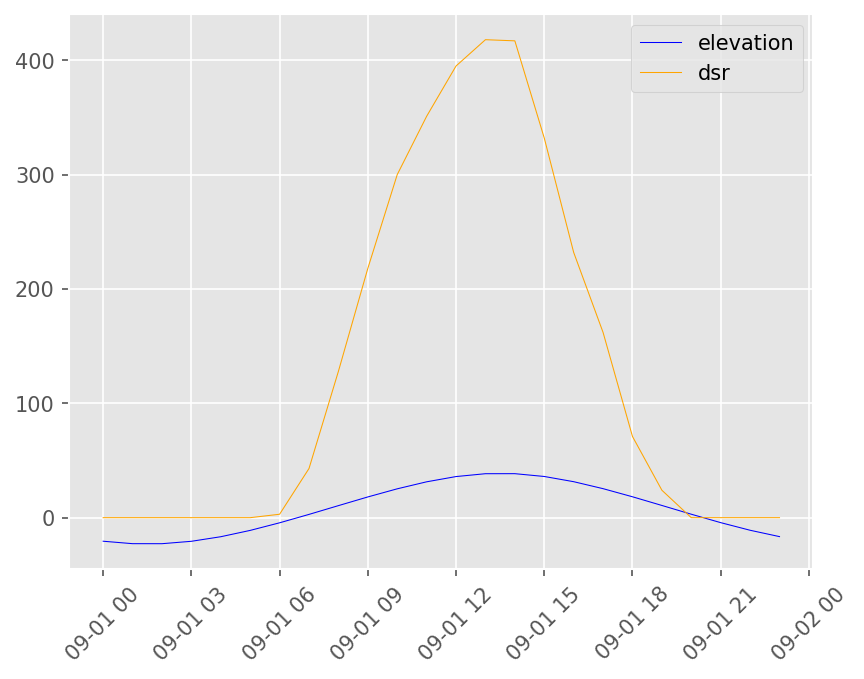

In [78]:
plt.plot(x_time[0:24], y_el[0:24], color='b', linewidth=0.5, label='elevation')
plt.plot(x_time[0:24], y_dsr[0:24], color='orange', linewidth=0.5, label='dsr')
plt.xticks(rotation=45)
plt.legend()

#### 3. Include Installed Capacity

In [79]:
train.date = train.date.astype('datetime64[ns]')
train.county = train.county.astype('int')
train = pd.merge(train, client_df, on=['date', 'county', 'is_business', 'product_type'], how='left')

In [80]:
client_df.county = client_df.county.astype('category')
train.county = train.county.astype('category')
client_df.is_business = client_df.is_business.astype('category')
train.is_business = train.is_business.astype('category')
client_df.product_type = client_df.product_type.astype('category')
train.product_type = train.product_type.astype('category')

#### 2a. fill NaN's with installed_capacity that was most recent

In [81]:
train_na = train[train.installed_capacity.isna()]
train = train[~train.installed_capacity.isna()]
train_na.county = train_na.county.astype('int')
train_na['installed_capacity'] = train_na[['county', 'is_business', 'product_type']].apply(lambda x: client_last_lookup[x[0]][x[1]][x[2]]['installed_capacity'], axis=1)
train_na['eic_count'] = train_na[['county', 'is_business', 'product_type', 'eic_count']].apply(lambda x: client_last_lookup[x[0]][x[1]][x[2]]['eic_count'], axis=1)

In [82]:
train = pd.concat([train, train_na], axis=0)

### Energy Pricing

In [83]:
train = pd.merge(train, electricity_df[['forecast_date', 'euros_per_mwh']], left_on=['datetime'], right_on=['forecast_date'], how='left')

In [84]:
train = pd.merge(train, gas_df, left_on=['date'], right_on=['forecast_date'], how='left')

### Solar Production Analysis

In [85]:
train.columns

Index(['county', 'datetime', 'is_business', 'product_type', 'target',
       'is_consumption', 'data_block_id_x', 'row_id', 'prediction_unit_id',
       'date', 'time', 'year', 'day_of_year', 'datediff_in_days', 'hour',
       'hour_sine', 'hour_cosine', 'dayofweek', 'dayofweek_sine',
       'dayofweek_cosine', 'week', 'week_sine', 'week_cosine', 'month',
       'month_sine', 'month_cosine', 'sample_point', 'latitude', 'longitude',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'multiplier', 'utc_offset', 'declination_rad', 'EoT', 'LSTM', 'TC',
       'LST', 'HSA', 'HRA_rad', 'latitude_rad', 'elevation_rad', 'elevation',
       'eic_count', 'installed_capacity', 'data_block_id_y', 'forecast_date_x',
       'euros_per_mwh', 'forecast_date_y', 'lowest_pr

In [86]:
X_columns = [
    'county', 'latitude', 'longitude', 'is_consumption', 'is_business', 'product_type',
    'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 
    'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
    'windspeed_10m', 'winddirection_10m',
    'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
    'day_of_year', 'utc_offset',
    'dayofweek', 'dayofweek_sine', 'dayofweek_cosine', 
    'hour', 'hour_sine', 'hour_cosine',
    'week', 'week_sine', 'week_cosine',
    'month', 'month_sine', 'month_cosine',
    'elevation', 'eic_count', 'installed_capacity', 
    'euros_per_mwh', 'lowest_price_per_mwh', 'highest_price_per_mwh'
]
y_columns = ['target']

X = train[X_columns]
y = train[y_columns]

In [87]:
pca_lookup = {
    'location': ['target', 'county', 'latitude', 'longitude'],
    'type': ['target', 'is_consumption', 'is_business', 'product_type'],
    'weather': ['target', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
                'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
                'windspeed_10m', 'winddirection_10m',
                'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'elevation'],
    'time': ['target', 'day_of_year', 'utc_offset', 
             'dayofweek', 'dayofweek_sine', 'dayofweek_cosine', 
             'hour', 'hour_sine', 'hour_cosine', 
             'week', 'week_sine', 'week_cosine',
             'month', 'month_sine', 'month_cosine'],
    'price': ['target', 'eic_count', 'installed_capacity', 'euros_per_mwh', 'lowest_price_per_mwh', 'highest_price_per_mwh']
}


### Plot Correlation PCA

In [ ]:
plt.figure(figsize=(16, 6))
group = 'weather'
test_columns = pca_lookup[group]
heatmap = sns.heatmap(train[test_columns].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Correlation Heatmap {group}', fontdict={'fontsize':18}, pad=12)

# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

### Split Train/Test 

In [91]:
category_columns = ['county', 'is_business', 'product_type', 'prediction_unit_id']

for col in category_columns:
    # X[col] = X[col].astype('category')
    try:
        del X[col]
    except:
        pass

In [92]:
y = y.fillna(0)

In [120]:
train_p = train[train.is_consumption == 0]
train_c = train[train.is_consumption == 1]

X_p = train_p[important_cols]
y_p  = train_p[["target"]]

X_c = train_c[important_cols]
y_c = train_c[["target"]]

In [121]:
y_p = y_p.fillna(0)
y_c = y_c.fillna(0)

In [148]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,
    n_jobs:int=1,
) -> XGBRegressor:
    '''
    Train a xgboost regressor with L1 loss
    '''
    model = XGBRegressor(
        objective='reg:absoluteerror',
        device="cuda",
        tree_method='hist',
        n_jobs=n_jobs,
        base_score=y_p.target.mean()
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    
    return model.fit(X,y)

In [155]:
params = {
  "learning_rate": 0.1,
  "max_depth": 5,
  "objective": "reg:absoluteerror",
  "tree_method": "hist",
  "device": "cuda",
}

In [156]:
model_c = fit_model(X_c, y_c, n_jobs=1000, config=params)

In [157]:
model_p = fit_model(X_p, y_p, n_jobs=1000, config=params)

In [164]:
train_c['target'] = train_c['target'].fillna(0)
train_set_ndx = round(len(train_c['target']) * 0.8)

In [166]:
test_set_ndx = len(train_c) - train_set_ndx

In [202]:
important_cols = ['installed_capacity', 'shortwave_radiation', 'direct_solar_radiation', 
                  'longitude', 'latitude', 'day_of_year', 'hour', 'temperature', 
                  'cloudcover_total', 'rain', 'snowfall', 'week_cosine', 'elevation']
# important_cols.append('target')

In [203]:
train_c = train_c.reset_index(drop=True)
train_c.target = train_c.target.fillna(0)

MemoryError: Unable to allocate 1.28 GiB for an array with shape (40, 4292342) and data type float64

In [177]:
test_set_c = train_c.iloc[0:test_set_ndx][important_cols]
train_set_c = train_c.iloc[test_set_ndx: train_set_ndx][important_cols]

In [191]:
dtrain_p = xgboost.DMatrix(data=X_p, label=y_p)

In [197]:
# num_round = 10
# evallist = [(train_set_c[important_cols], 'train'), (test_set_c[important_cols], 'eval')]
# params = {'max_depth': 5, 'eta': 1, 'objective': 'reg:absoluteerror', 'nthread': 4, 'eval_metric': 'target', 'device':'cuda'}

In [201]:
num_parallel_tree = 4
num_boost_round = 16
# total number of built trees is num_parallel_tree * num_classes * num_boost_round

# We build a boosted random forest for classification here.
booster = xgboost.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain_p)

XGBoostError: [02:41:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\multiclass_obj.cu:123: SoftmaxMultiClassObj: label must be in [0, num_class).

In [198]:
 new_model_c = xgboost.train(params, dtrain_p, num_boost_round = 1000, early_stopping_rounds = 10)

XGBoostError: [02:40:12] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\metric\metric.cc:49: Unknown metric function target

In [188]:
model_c.train(param, num_round=10)

AttributeError: 'XGBRegressor' object has no attribute 'train'

### Test Data

In [97]:
test = pd.read_csv(os.path.join(os.getcwd(), "example_test_files/test.csv"))

In [130]:
import random

In [154]:
for i in range(100):
    ndx = random.randint(0, len(X_p))

    test_row = np.asarray([X_p.iloc[ndx]])
    y_hat = model_p.predict(test_row)
    actual_val = y_p.iloc[ndx]
    
    # summarize prediction
    print('Predicted: %.3f' % y_hat)
    print('Actual: %.3f' % actual_val)

Predicted: 4546.393
Actual: 2.061
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.270
Predicted: 4546.393
Actual: 0.192
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 34.366
Predicted: 4546.393
Actual: 0.002
Predicted: 4546.393
Actual: 4.048
Predicted: 4546.393
Actual: 23.485
Predicted: 4546.393
Actual: 3.570
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 1.066
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.890
Predicted: 4546.393
Actual: 81.053
Predicted: 4546.393
Actual: 73.185
Predicted: 4546.393
Actual: 0.001
Predicted: 4546.393
Actual: 19.427
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 1.618
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 304.286
Predicted: 4546.393
Actual: 2.448
Predicted: 4546.393
Actual: 0.000
Predicted: 4546.393
Actual: 0.000
Predict

In [103]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [104]:
y_preds = []
y_actuals = []
for ndx in X.index:
    test_row = np.asarray([X.iloc[ndx]])
    pred_val = model.predict(test_row)
    y_preds.append(pred_val)
    y_actuals.append(y.iloc[ndx])

# summarize prediction
# print('Predicted: %.3f' % yhat)
# print('Actual: %.3f' % actual_val)

KeyboardInterrupt: 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

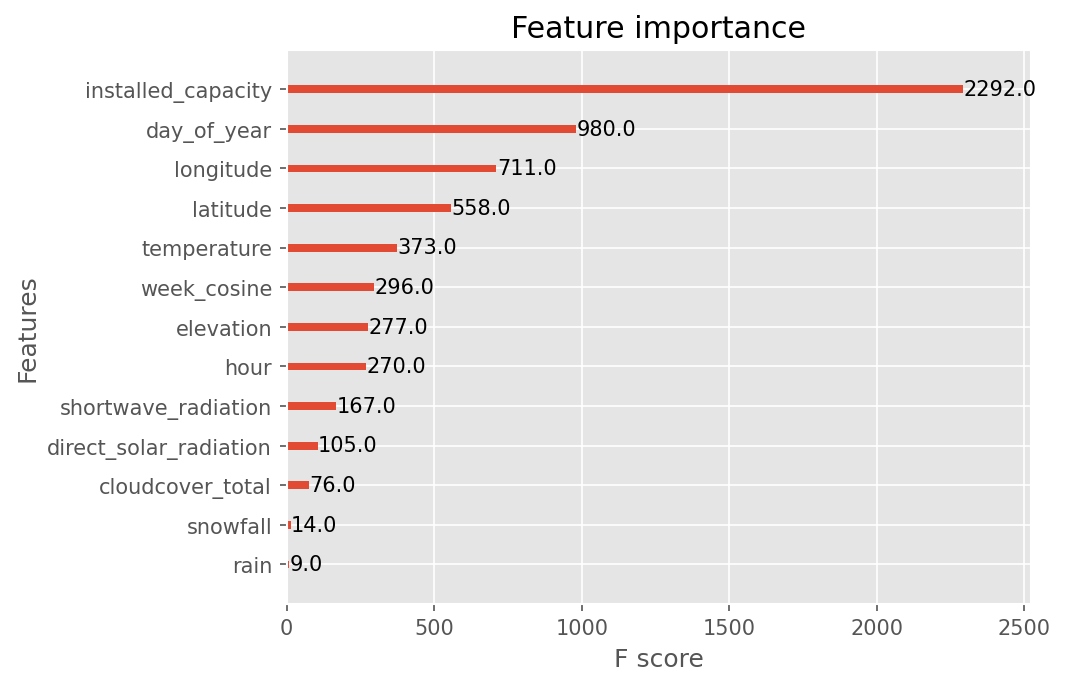

In [126]:
xgboost.plot_importance(model_c)

In [ ]:
times = spa.datetime.to_list()
plt.plot(times, y.target.to_list(), 'b', linewidth=0.3)
plt.plot(times, y_hat, 'o', linewidth=0.3)

### Visualize Solar Irradiance by County per Month

In [ ]:
# county_data['direct_solar_bin'] = bin_data(county_data['direct_solar_radiation'], k=6, interval="stdev")

In [ ]:
# for month in range(1, 13):

#     monthly_avg = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).median()
#     monthly_max = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).max()
#     monthly_avg = pd.merge(monthly_avg.reset_index(), counties, on='countyCodes')
#     monthly_max = pd.merge(monthly_max.reset_index(), counties, on='countyCodes')

#     fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

#     divider_0 = make_axes_locatable(ax[0])
#     divider_1 = make_axes_locatable(ax[1])

#     cax_0 = divider_0.append_axes("top", size="5%", pad=0.5)
#     cax_1 = divider_1.append_axes("bottom", size="5%", pad=0.5)

#     monthly_avg.plot(
#         column="direct_solar_radiation",
#         ax=ax[0],
#         legend=True,
#         cax=cax_0,
#         legend_kwds={"label": f"Nom Direct Solar Radiation: Month {month}", "orientation": "horizontal"},
#         cmap='OrRd'
#     );
#     monthly_max.plot(
#         column="direct_solar_radiation",
#         ax=ax[1],
#         legend=True,
#         cax=cax_1,
#         legend_kwds={"label": f"Max Direct Solar Radiation: Month {month}", "orientation": "horizontal"}
#     );
    
    
#     print("\n\n\n")

### Other Plots

In [ ]:
# counts for the country,store,product
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train_df, x=column, ax=axs[i])

_ = fig.tight_layout()

In [ ]:
train_avgd = (
    train_df
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

In [ ]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

In [ ]:
# get train attributes
extract_dt_attributes(train_df)

In [ ]:
categorical_cols = ['county', 'product_type']
for column in categorical_cols:
    train_df[column] = train_df[column].astype('category')

In [ ]:
train_df[train_df['is_consumption'] == 0][['target', 'hour', 'month']].groupby(by=['month', 'hour']).mean()

In [ ]:
client_df[(client_df.data_block_id == 4) & (client_df.county == 0)]

In [ ]:
train_df[(train_df.data_block_id == 1) & (train_df.county == 0)]

In [ ]:
print(f"Total Observed Hours: {len(train_df.datetime.drop_duplicates().to_list())}")
print(f"Counties: {len(train_df.county.drop_duplicates().to_list())}")
print(f"Prediction Types: {len(train_df.prediction_unit_id.drop_duplicates().to_list())}")
print(f"Data Blocks: {len(train_df.data_block_id.drop_duplicates().to_list())}")

<h4>Business</h4|>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list()[0:1]:
        cpt_df = county_df[county_df.product_type == product_type]
        consumed_df = cpt_df[(cpt_df.is_business == 1) & (cpt_df.is_consumption == 1)]
        print(consumed_df.sort_values('datetime', ascending=True))
        x = range(len(consumed_df))
        y = consumed_df.target.to_list()
        plt.plot(x, y)
        plt.show()



<h4>Consumer</h4>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list():
        cpt_df = county_df[county_df.product_type == product_type]
        non_biz_cpt_df = cpt_df[cpt_df.is_business == 0]
        print(non_biz_cpt_df)